③ データ拡張（Data Augmentation）
▶ 画像データ拡張（Image Augmentation）
画像の回転、反転、ノイズ追加によるデータ増強。

In [1]:
from torchvision import transforms
from PIL import Image

img = Image.open('example.jpg')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 水平反転
    transforms.RandomRotation(30),      # ±30度のランダム回転
])

augmented_img = transform(img)
augmented_img.save('augmented_example.jpg')


▶ テキストデータ拡張（Text Augmentation）
同義語置換や翻訳を活用する方法（ここでは簡易的な例を示します）。

In [2]:
# 単純な同義語置換の例
synonyms = {'AI': ['人工知能', '機械学習'], '重要': ['大切', '不可欠']}
text = 'AIは重要です'

for word, synonym_list in synonyms.items():
    for synonym in synonym_list:
        augmented_text = text.replace(word, synonym)
        print(augmented_text)


人工知能は重要です
機械学習は重要です
AIは大切です
AIは不可欠です


▶ 生成データ拡張（Generative Augmentation：GAN、VAEs）
GANなどを使った画像生成の簡易例（理論のみ、コードは高度なため簡略化）。

GAN（敵対的生成ネットワーク）
学習済GANモデルで新規画像を生成しデータセットを拡張。

VAE（変分オートエンコーダ）
潜在変数をサンプリングし、多様なデータを生成する。



| 項目      | VAE           | GAN                               |
| ------- | ------------- | --------------------------------- |
| モデル構造   | 確率的生成（再構成＋KL） | 敵対的訓練（Generator vs Discriminator） |
| 生成画像の品質 | ややぼやける傾向      | シャープで自然                           |
| 安定性     | 安定（損失関数あり）    | 不安定なこともある                         |
| 用途例     | 変分推論、潜在空間の可視化 | 高品質画像生成、画像変換など                    |


✅ ① VAE：変分オートエンコーダによる画像生成
MNIST（手書き数字）を使って、潜在変数から新しい画像を生成

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 172kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.41MB/s]


Epoch 1, Loss: 166.2175
Epoch 2, Loss: 122.9108
Epoch 3, Loss: 115.3333
Epoch 4, Loss: 112.0749
Epoch 5, Loss: 110.2240


/home/lius/miniconda3/envs/agent_ragenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lius/miniconda3/envs/agent_ragenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12424 (\N{HIRAGANA LETTER YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lius/miniconda3/envs/agent_ragenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lius/miniconda3/envs/agent_ragenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lius/miniconda3/envs/agent_ragenv/lib/python3.10/site-packages/IPython/core/py

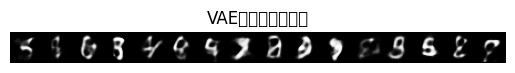

In [3]:
# 日本語注釈付き：VAEでMNIST画像を生成
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ハイパーパラメータ
BATCH_SIZE = 128
LATENT_DIM = 20
EPOCHS = 5

# データロード
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)

# VAEモデル定義
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, LATENT_DIM)  # 平均
        self.fc22 = nn.Linear(400, LATENT_DIM)  # 分散（対数）
        self.fc3 = nn.Linear(LATENT_DIM, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 損失関数（再構成誤差 + KLD）
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 学習
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss = loss_function(recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(loader.dataset):.4f}')

# 生成（潜在変数zをサンプリングして画像を生成）
model.eval()
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(-1, 1, 28, 28)

# 表示
grid_img = torch.cat([img for img in sample], dim=2).squeeze()
plt.imshow(grid_img, cmap='gray')
plt.title('VAEによる生成画像')
plt.axis('off')
plt.show()


✅ ② GAN：敵対的生成ネットワークによる画像生成
GeneratorとDiscriminatorを対立学習させ、現実風画像を生成します。

Epoch 1, D Loss: 0.4719, G Loss: 1.2713
Epoch 2, D Loss: 0.8782, G Loss: 0.9553
Epoch 3, D Loss: 1.1618, G Loss: 0.8877
Epoch 4, D Loss: 0.8611, G Loss: 1.1261
Epoch 5, D Loss: 1.5434, G Loss: 0.6853


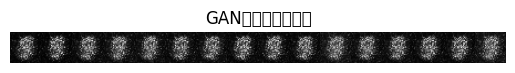

In [4]:
# 日本語注釈付き：シンプルなGAN（MNIST用）
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ハイパーパラメータ
latent_dim = 100
epochs = 5
batch_size = 128

# データセット（MNIST）
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

# Generator定義
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

# Discriminator定義
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x.view(-1, 784))

# モデル準備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002)
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002)

# 学習
for epoch in range(epochs):
    for x, _ in loader:
        x = x.to(device)
        batch_size = x.size(0)

        # 本物/偽物ラベル
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # 1. Discriminator更新
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)

        loss_D = criterion(D(x), real) + criterion(D(fake_imgs.detach()), fake)
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # 2. Generator更新
        loss_G = criterion(D(fake_imgs), real)
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f'Epoch {epoch+1}, D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}')

# 生成
G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    gen_imgs = G(z).cpu().view(-1, 1, 28, 28)

# 表示
grid_img = torch.cat([img for img in gen_imgs], dim=2).squeeze()
plt.imshow(grid_img, cmap='gray')
plt.title('GANによる生成画像')
plt.axis('off')
plt.show()
